In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
from scipy import linalg
from scipy import sparse
from scipy import signal

import matplotlib.pyplot as plt

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2023-09-05 15:34:05.931625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


# Define functions to simulate dynamics

In [3]:
from scipy.integrate import solve_ivp

def fio_rect(x):
    return np.fmax(x,0)

def dynamics_system(y,inp_ff,Wrec,\
                    gamma_rec,gamma_ff,k,n,tau):
    argE = gamma_rec[0] * np.dot(Wrec[0,0],y[0]) + gamma_rec[1] * np.dot(Wrec[0,1],y[1]) + gamma_ff * inp_ff[0]
    argI = gamma_rec[0] * np.dot(Wrec[1,0],y[0]) + gamma_rec[1] * np.dot(Wrec[1,1],y[1]) + gamma_ff * inp_ff[1]
    return 1./tau*( -y + np.stack([k[0]*fio_rect(argE)**n[0],k[1]*fio_rect(argI)**n[1]]))

def integrate(y0,inp,Wrec,gamma_rec,k,n,dt,Nt):
    y = y0
    for t_idx in range(Nt):
        out = dynamics_system(y,inp,Wrec,gamma_rec,1.0,k,n,1.0)
        dy = out
        y = y + dt*dy
    return y
#     def ode_fun(t,y):
#         return dynamics_system(y,inp,W4to4,gamma_rec,1.0,N4*N4,1.0)
#     sol = solve_ivp(ode_fun,[0,dt*Nt],y0,method='RK23',first_step=dt)
#     return np.array([sol.y[:N4**2,-1].reshape((N4,N4)),sol.y[N4**2:,-1].reshape((N4,N4))])

# Calculate the typical length scale in RELU network

In [4]:
config_name = "big_homo"
Version = -1
config_dict,Npop,_,_,_,N,rA = uf.get_network_size(config_name,False)

W = np.load('homo_W4to4_N4={:d}.npy'.format(N))
W = W.reshape((2,N**2,2,N**2)).transpose((0,2,1,3))

In [5]:
rates = np.load('homo_rates_N4={:d}.npy'.format(N)).reshape((-1,2,N,N))
n_inp = rates.shape[0]

# fps_dat = np.zeros(int(np.ceil(N//2*np.sqrt(2))))
# fps_err = np.zeros(int(np.ceil(N//2*np.sqrt(2))))
fps_dat = np.zeros(N//2)
fps_err = np.zeros(N//2)

grid = np.arange(-N//2,N//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(N//2*np.sqrt(2)))+0.5)

for i in range(10):
    for j in range(10):
        idx = i*10+j
        
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,0]-np.nanmean(rates[idx,0]))))**2
        for idx in range(N//2):
            fps_dat[idx] += np.mean(fp2[bin_idxs == idx])
            fps_err[idx] += np.var(fp2[bin_idxs == idx])
            
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,1]-np.nanmean(rates[idx,1]))))**2
        for idx in range(N//2):
            fps_dat[idx] += np.mean(fp2[bin_idxs == idx])
            fps_err[idx] += np.var(fp2[bin_idxs == idx])

fps_dat /= 2*n_inp
fps_err /= 2*n_inp
fps_err = np.sqrt(fps_err / (2*n_inp))
# fps_dat /= n_inp
# fps_err /= n_inp
# fps_err = np.sqrt(fps_err / n_inp)

Λ = 15.0


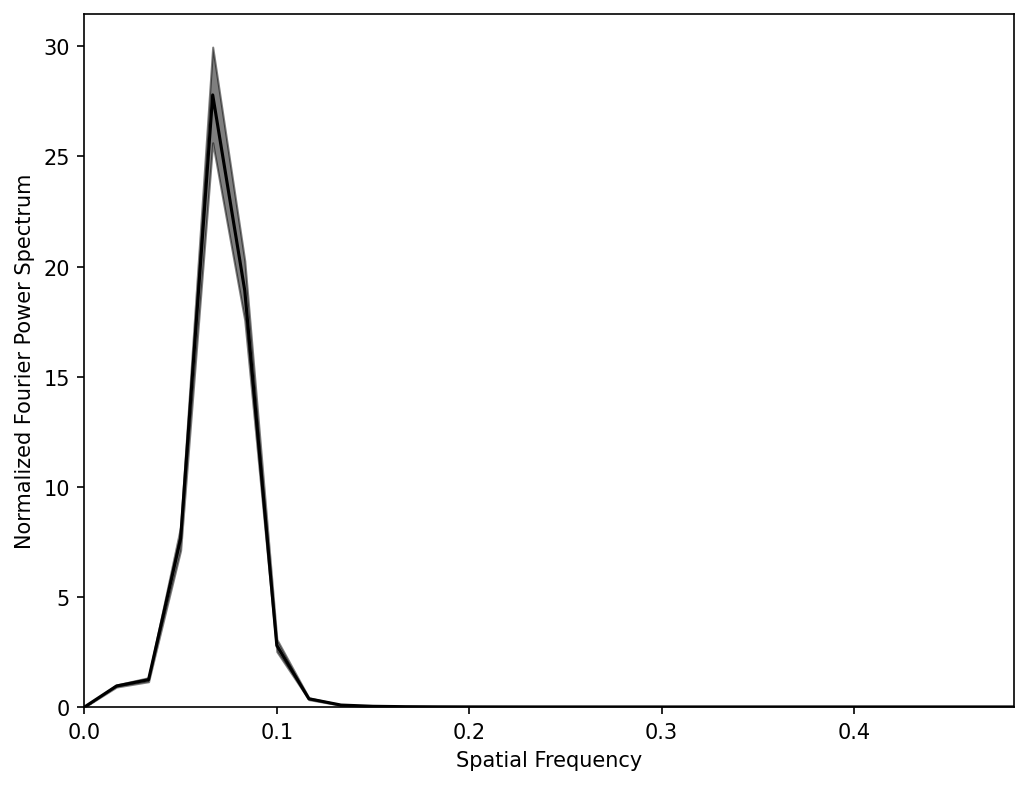

In [6]:
fig,axs = plt.subplots(1,1,figsize=(8,6),dpi=150)

# freqs = np.arange(int(np.ceil(N//2*np.sqrt(2))))/N
freqs = np.arange(N//2)/N

axs.plot(freqs,fps_dat/np.sum(fps_dat)*N,'k')
axs.fill_between(freqs,(fps_dat+fps_err)/np.sum(fps_dat)*N,
                 (fps_dat-fps_err)/np.sum(fps_dat)*N,
                 color='k',alpha=0.5)

axs.set_xlabel('Spatial Frequency')
axs.set_ylabel('Normalized Fourier Power Spectrum')

axs.set_xlim(0,(N//2-1)/N)
axs.set_ylim(0,None)

Lam = 1/freqs[np.argmax(fps_dat)]
print('Λ =',Lam)

# Solve for SSN parameters that would give correct correlation patterns

In [66]:
nE = 1.8
nI = 2

a = W.sum(-1).mean(-1)
n = np.array([nE,nI])

In [74]:
I = 1*np.array([1,1.1])

# VdivI = np.linalg.inv(np.eye(2)-1.02 * a/n[None,:]/I[:,None])@np.ones(2)
# V = VdivI * I
V = np.linalg.inv(np.eye(2)-1.02 * a/n[None,:])@I
R = np.array([2,10])
k = R/(V**n)
kE = k[0]
kI = k[1]
# R = k*(V**n)

print('I =',I)
print('V =',V)
print('R =',R)

# gam = 1/(k*n*V**(n-1)*I)
gam = 1/(k*n*V**(n-1))

I = [1.  1.1]
V = [1.05538162 1.18150816]
R = [ 2 10]


In [10]:
gam*n*k*V**(n-1)

array([1., 1.])

# Verify that spatially uniform rates match expectation

In [11]:
config_name = "big_hetero"
Version = -1
config_dict,Npop,_,_,_,N,rA = uf.get_network_size(config_name,False)

W = np.load('hetero_W4to4_N4={:d}.npy'.format(N))
W = W.reshape((2,N**2,2,N**2)).transpose((0,2,1,3))

Text(0.5, 1.0, 'L2/3 I Cell (Pre)')

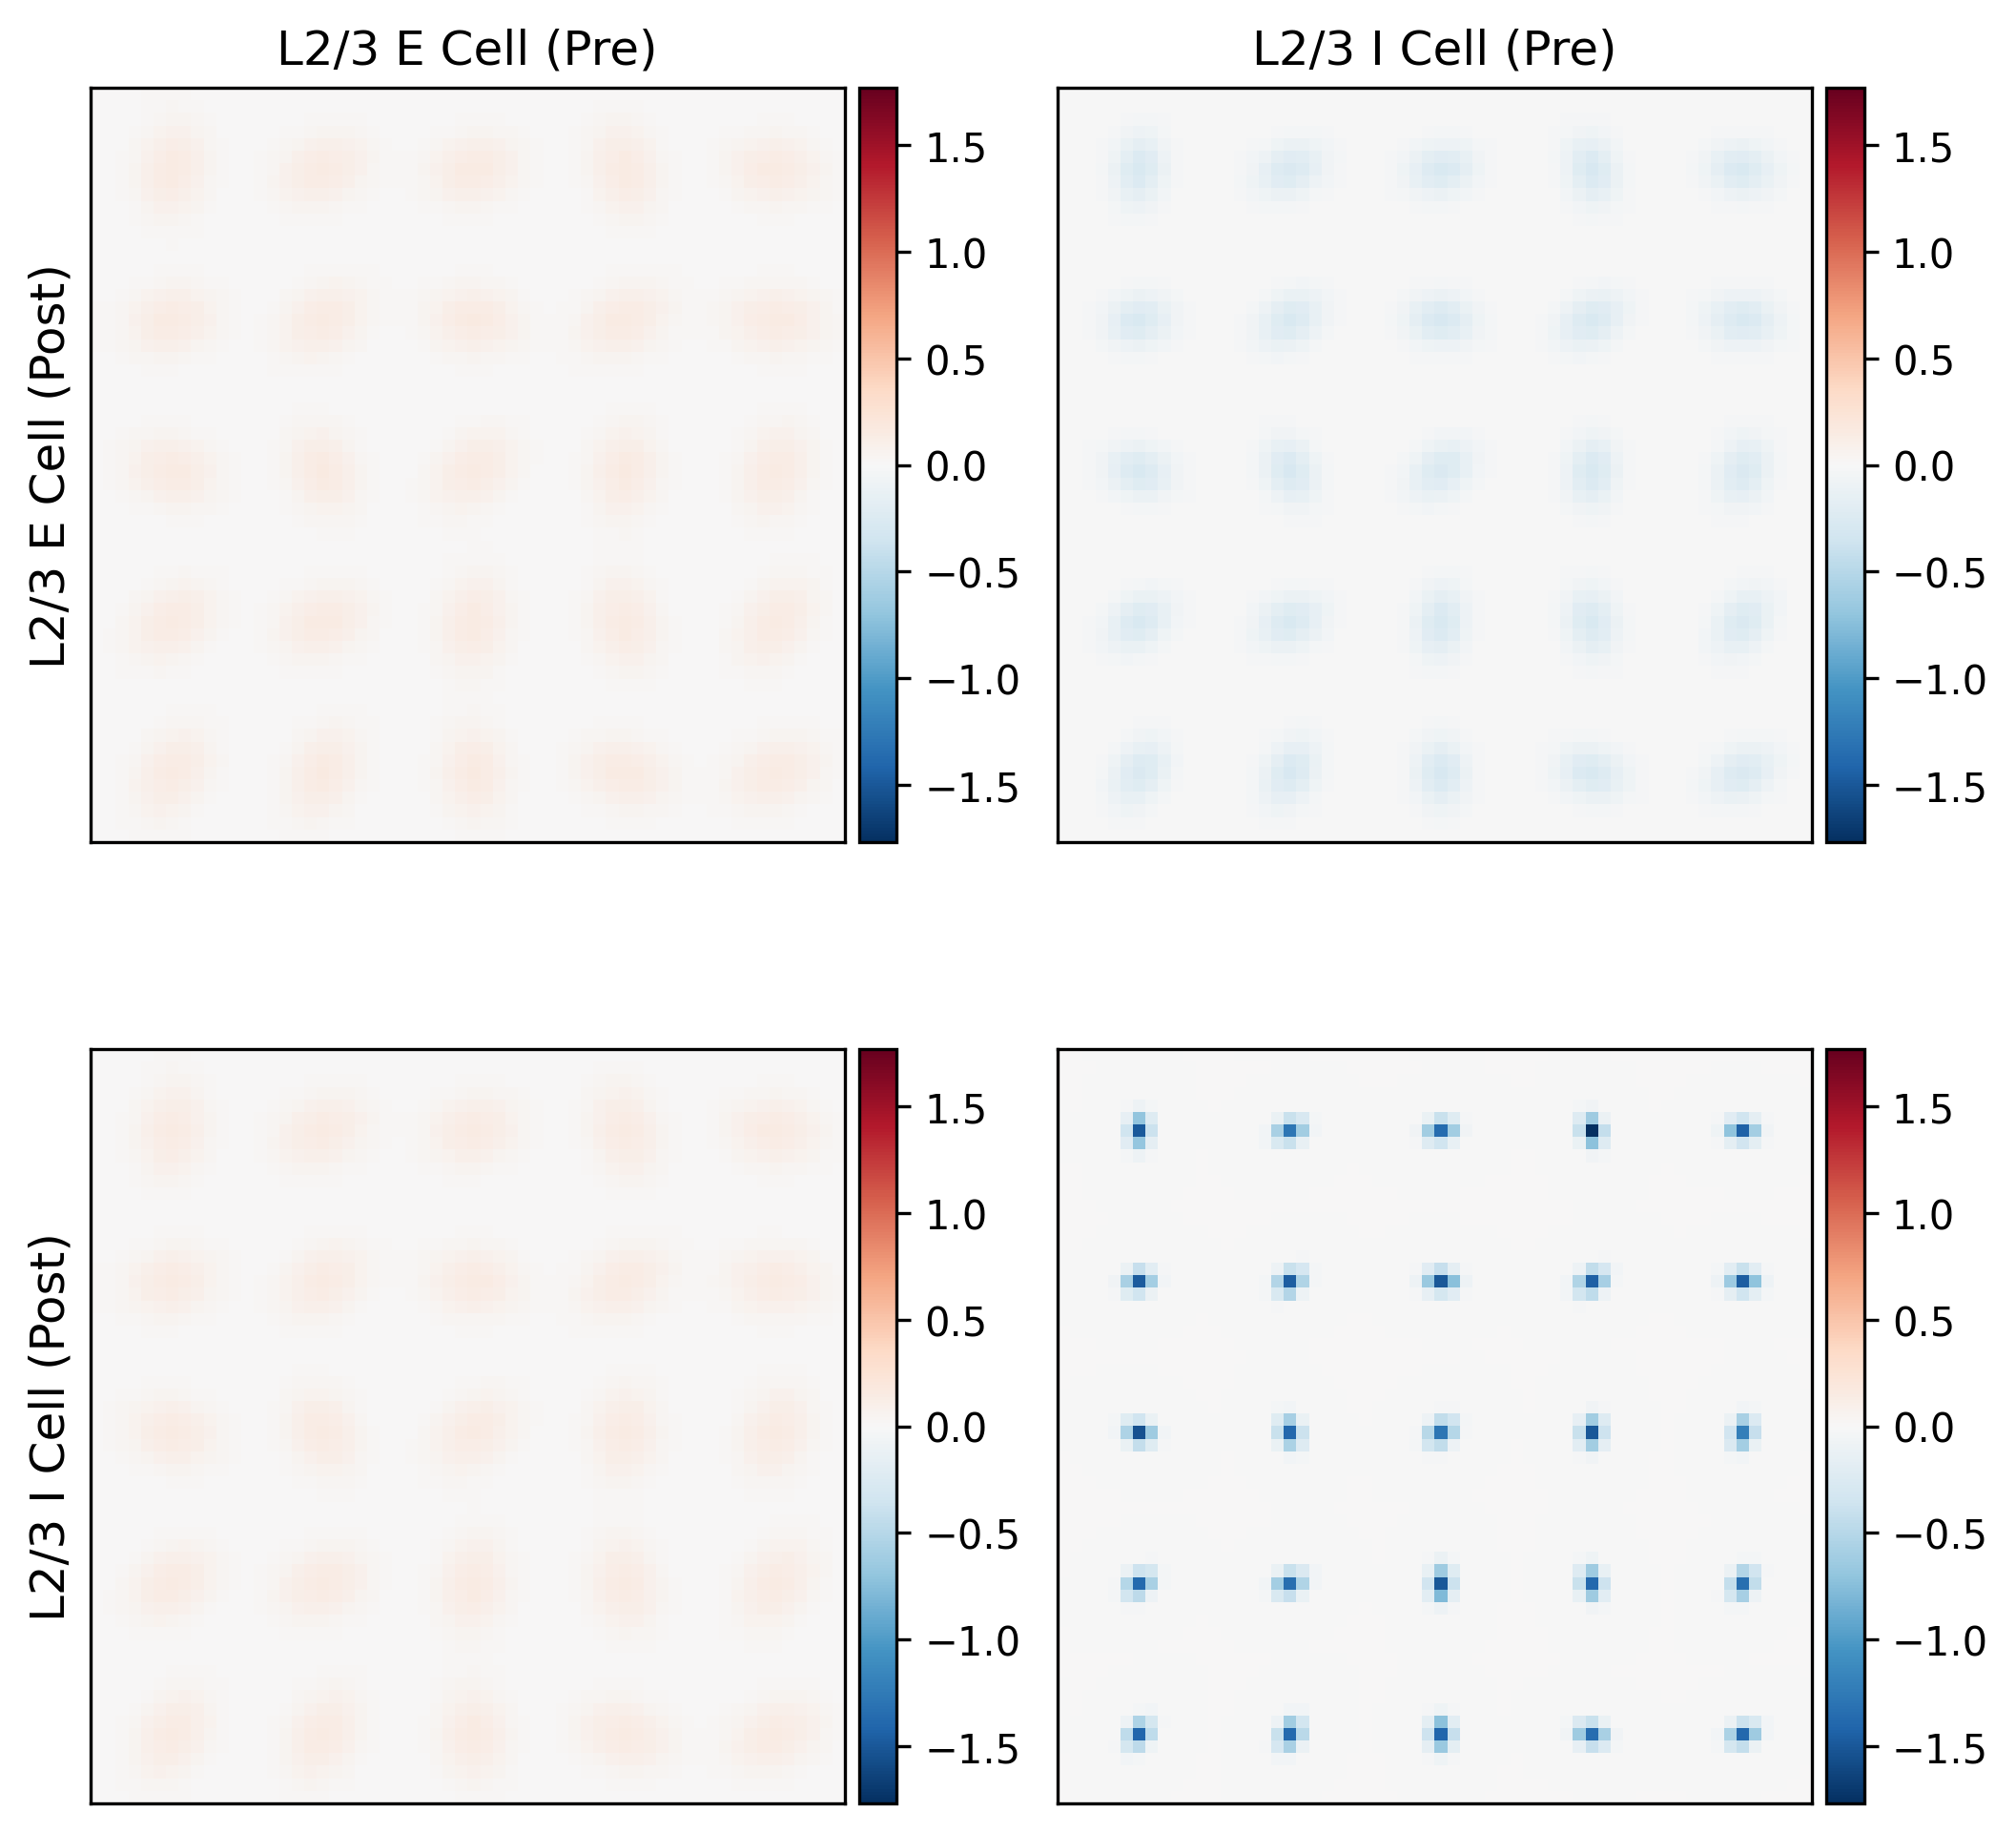

In [12]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

WEE = np.zeros((N,N))
WEI = np.zeros((N,N))
WIE = np.zeros((N,N))
WII = np.zeros((N,N))

idxs = np.arange(N//10,N,N//5)
for i in range(len(idxs)):
    for j in range(len(idxs)):
        rav_idx = np.ravel_multi_index([[idxs[i]],[idxs[j]]],(N,N))
        WEE += W[0,0][:,rav_idx].reshape(N,N)
        WEI += W[0,1][:,rav_idx].reshape(N,N)
        WIE += W[1,0][:,rav_idx].reshape(N,N)
        WII += W[1,1][:,rav_idx].reshape(N,N)

pf.imshowbar(fig,axs[0,0],WEE,
            vmin=-np.max(np.abs(W)),vmax=np.max(np.abs(W)),cmap='RdBu_r')
pf.imshowbar(fig,axs[0,1],WEI,
            vmin=-np.max(np.abs(W)),vmax=np.max(np.abs(W)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,0],WIE,
            vmin=-np.max(np.abs(W)),vmax=np.max(np.abs(W)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,1],WII,
            vmin=-np.max(np.abs(W)),vmax=np.max(np.abs(W)),cmap='RdBu_r')

axs[0,0].set_ylabel('L2/3 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L2/3 I Cell (Post)',fontsize=12)
axs[0,0].set_title('L2/3 E Cell (Pre)',fontsize=12)
axs[0,1].set_title('L2/3 I Cell (Pre)',fontsize=12)

# eigval,eigvec = sparse.linalg.eigs(W,1,which='LR')
# print(eigval)

In [13]:
unif_inp = I[:,None]*np.ones(N**2)[None,:]
unif_rate = integrate(np.ones((2,N**2)),unif_inp,W,1.02*gam,k,n,0.25,100)

In [14]:
print('expected R  =',R)
print('simulated R =',unif_rate.mean(-1))

expected R  = [ 2 10]
simulated R = [1.99848693 9.98902831]


In [15]:
x,y = np.meshgrid(np.linspace(-N//2,N//2-1,N),np.linspace(-N//2,N//2-1,N))
sig1 = 1.8
sig2 = 3.6
kern1 = 1./(np.sqrt(np.pi*2)*sig1)**2*np.exp((-x**2-y**2)/2./sig1**2)
kern2 = 1./(np.sqrt(np.pi*2)*sig2)**2*np.exp((-x**2-y**2)/2./sig2**2)
diff_gauss = kern1-kern2

In [16]:
n_inp = 4
eta = 1e-2
inps = np.zeros((n_inp,2,N,N))

ring_image = np.fft.fft2(np.fft.fftshift(diff_gauss))

rng = np.random.default_rng(0)
for inp_idx in range(n_inp):
    for pop_idx in range(2):
        random_matrix = np.fft.fft2(rng.normal(size=(N,N)))
        ring_ifft = np.real(np.fft.ifft2(ring_image*random_matrix))
        inps[inp_idx,pop_idx,:,:] = I[pop_idx]*(1 + eta*ring_ifft)

In [17]:
start = time.process_time()

rates = np.zeros_like(inps)
for inp_idx in range(n_inp):
    rates[inp_idx] = integrate(np.ones((2,N**2)),inps[inp_idx].reshape((2,-1)),W,1.02*gam,k,n,
                               0.25,100).reshape((2,N,N))
    
print('Simulating rate dynamics took',time.process_time() - start,'s')
# np.save('hetero_rates_ssn_N4={:d}'.format(N),rates.flatten())

# rates = sim_rates[0,:n_inp]

Simulating rate dynamics took 198.63368799999998 s


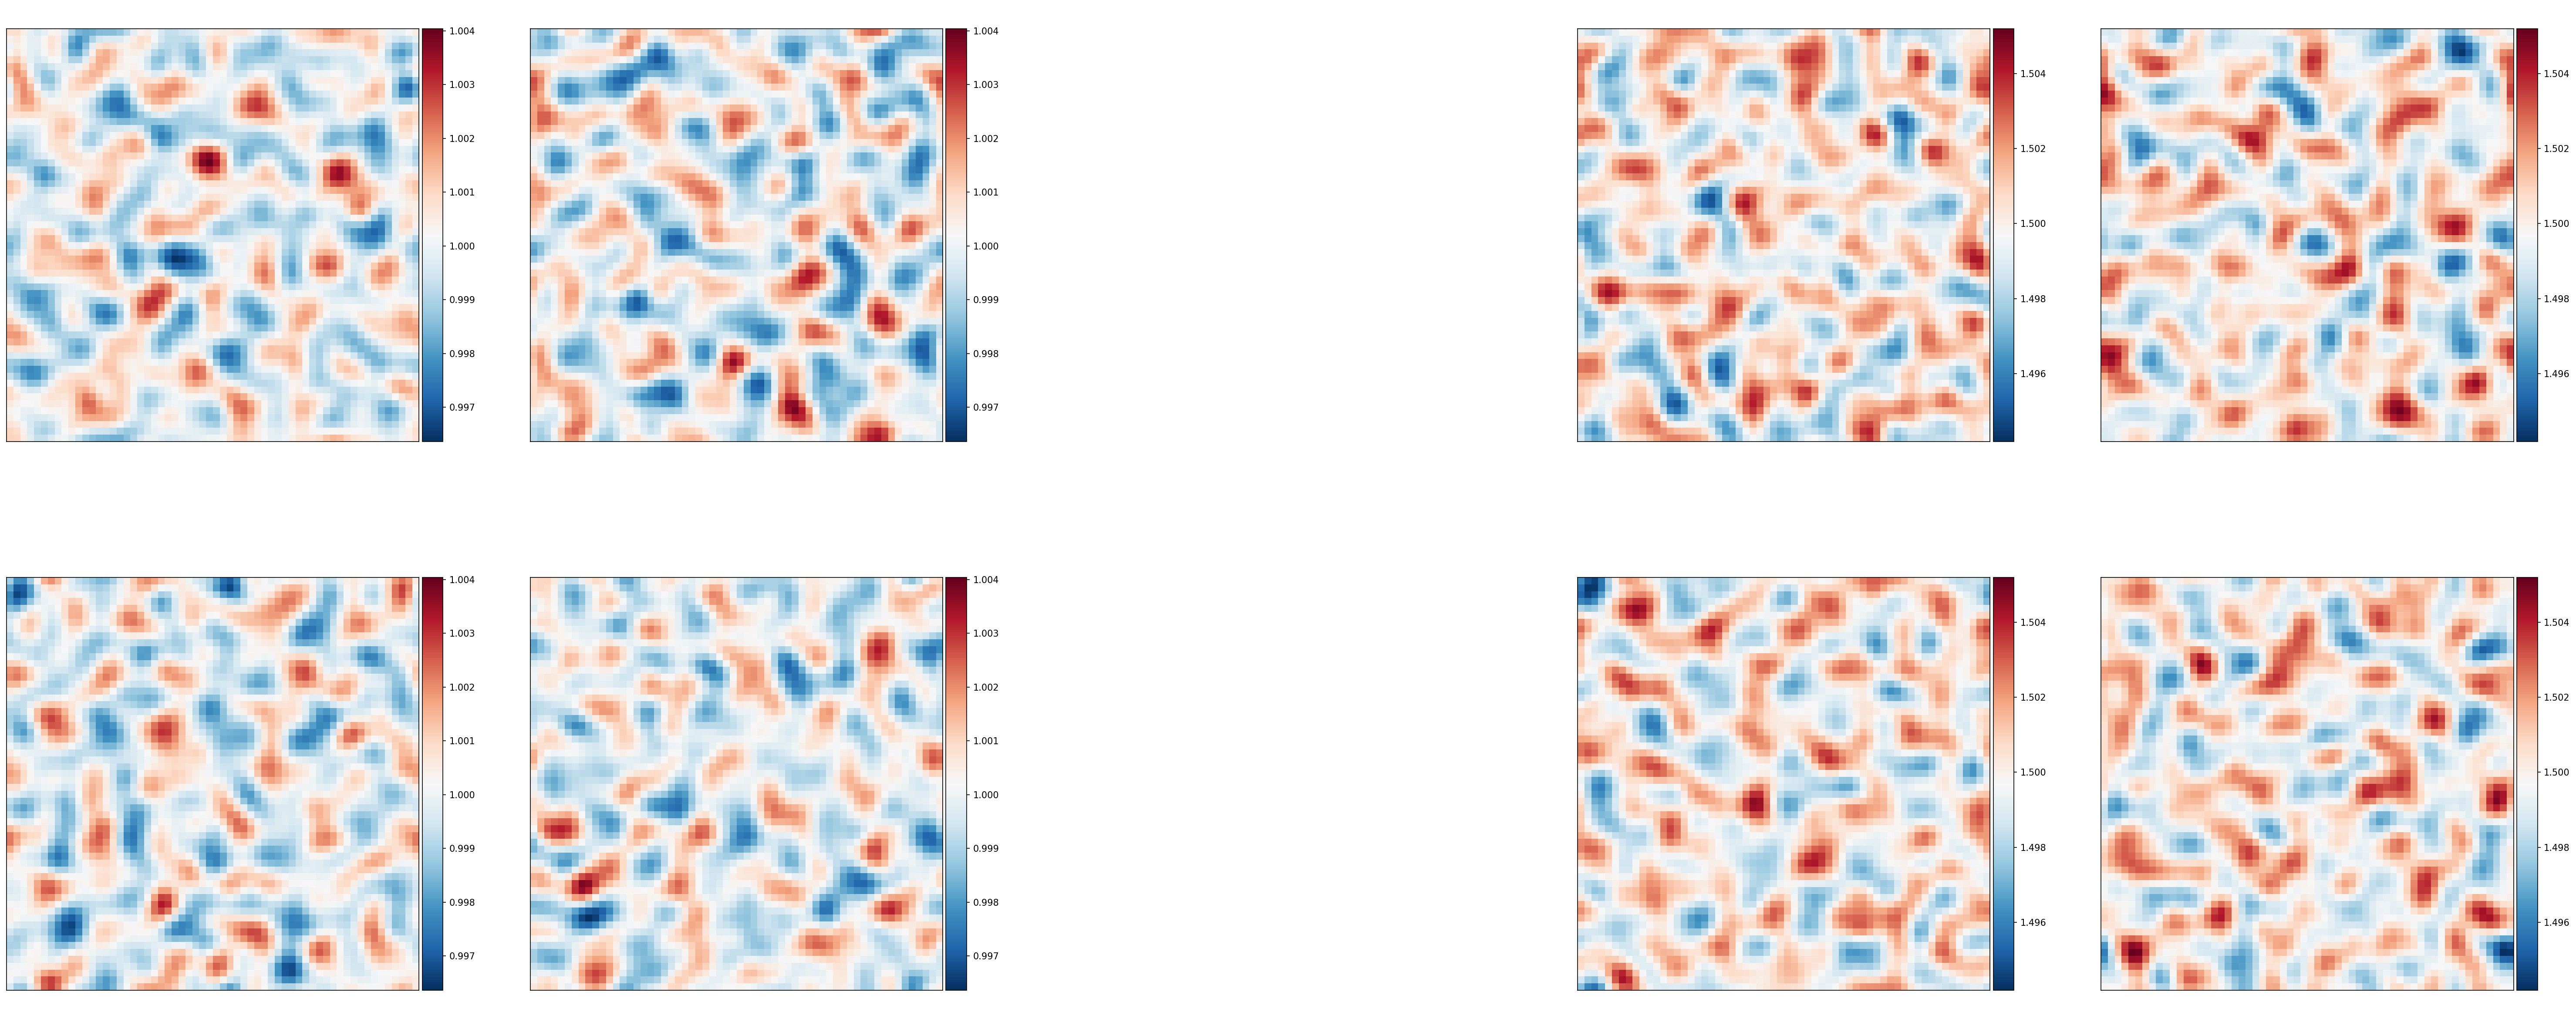

In [18]:
n_row = 2

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=((2*n_row+1)*10,n_row*10),dpi=150)

if n_row == 1:
    idx = 0
    axs[1].axis('off')
    pf.imshowbar(fig,axs[0],
                 inps[idx,0],cmap='RdBu_r',
                 vmin=np.min(inps[:,0]),vmax=np.max(inps[:,0]))
    pf.imshowbar(fig,axs[2],
                 inps[idx,1],cmap='RdBu_r',
                 vmin=np.min(inps[:,1]),vmax=np.max(inps[:,1]))
else:
    for i in range(n_row):
        axs[i,n_row].axis('off')
        for j in range(n_row):
            idx = i*n_row+j
            pf.imshowbar(fig,axs[i,j],
                         inps[idx,0],cmap='RdBu_r',
                         vmin=np.min(inps[:,0]),vmax=np.max(inps[:,0]))
            pf.imshowbar(fig,axs[i,n_row+j+1],
                         inps[idx,1],cmap='RdBu_r',
                         vmin=np.min(inps[:,1]),vmax=np.max(inps[:,1]))

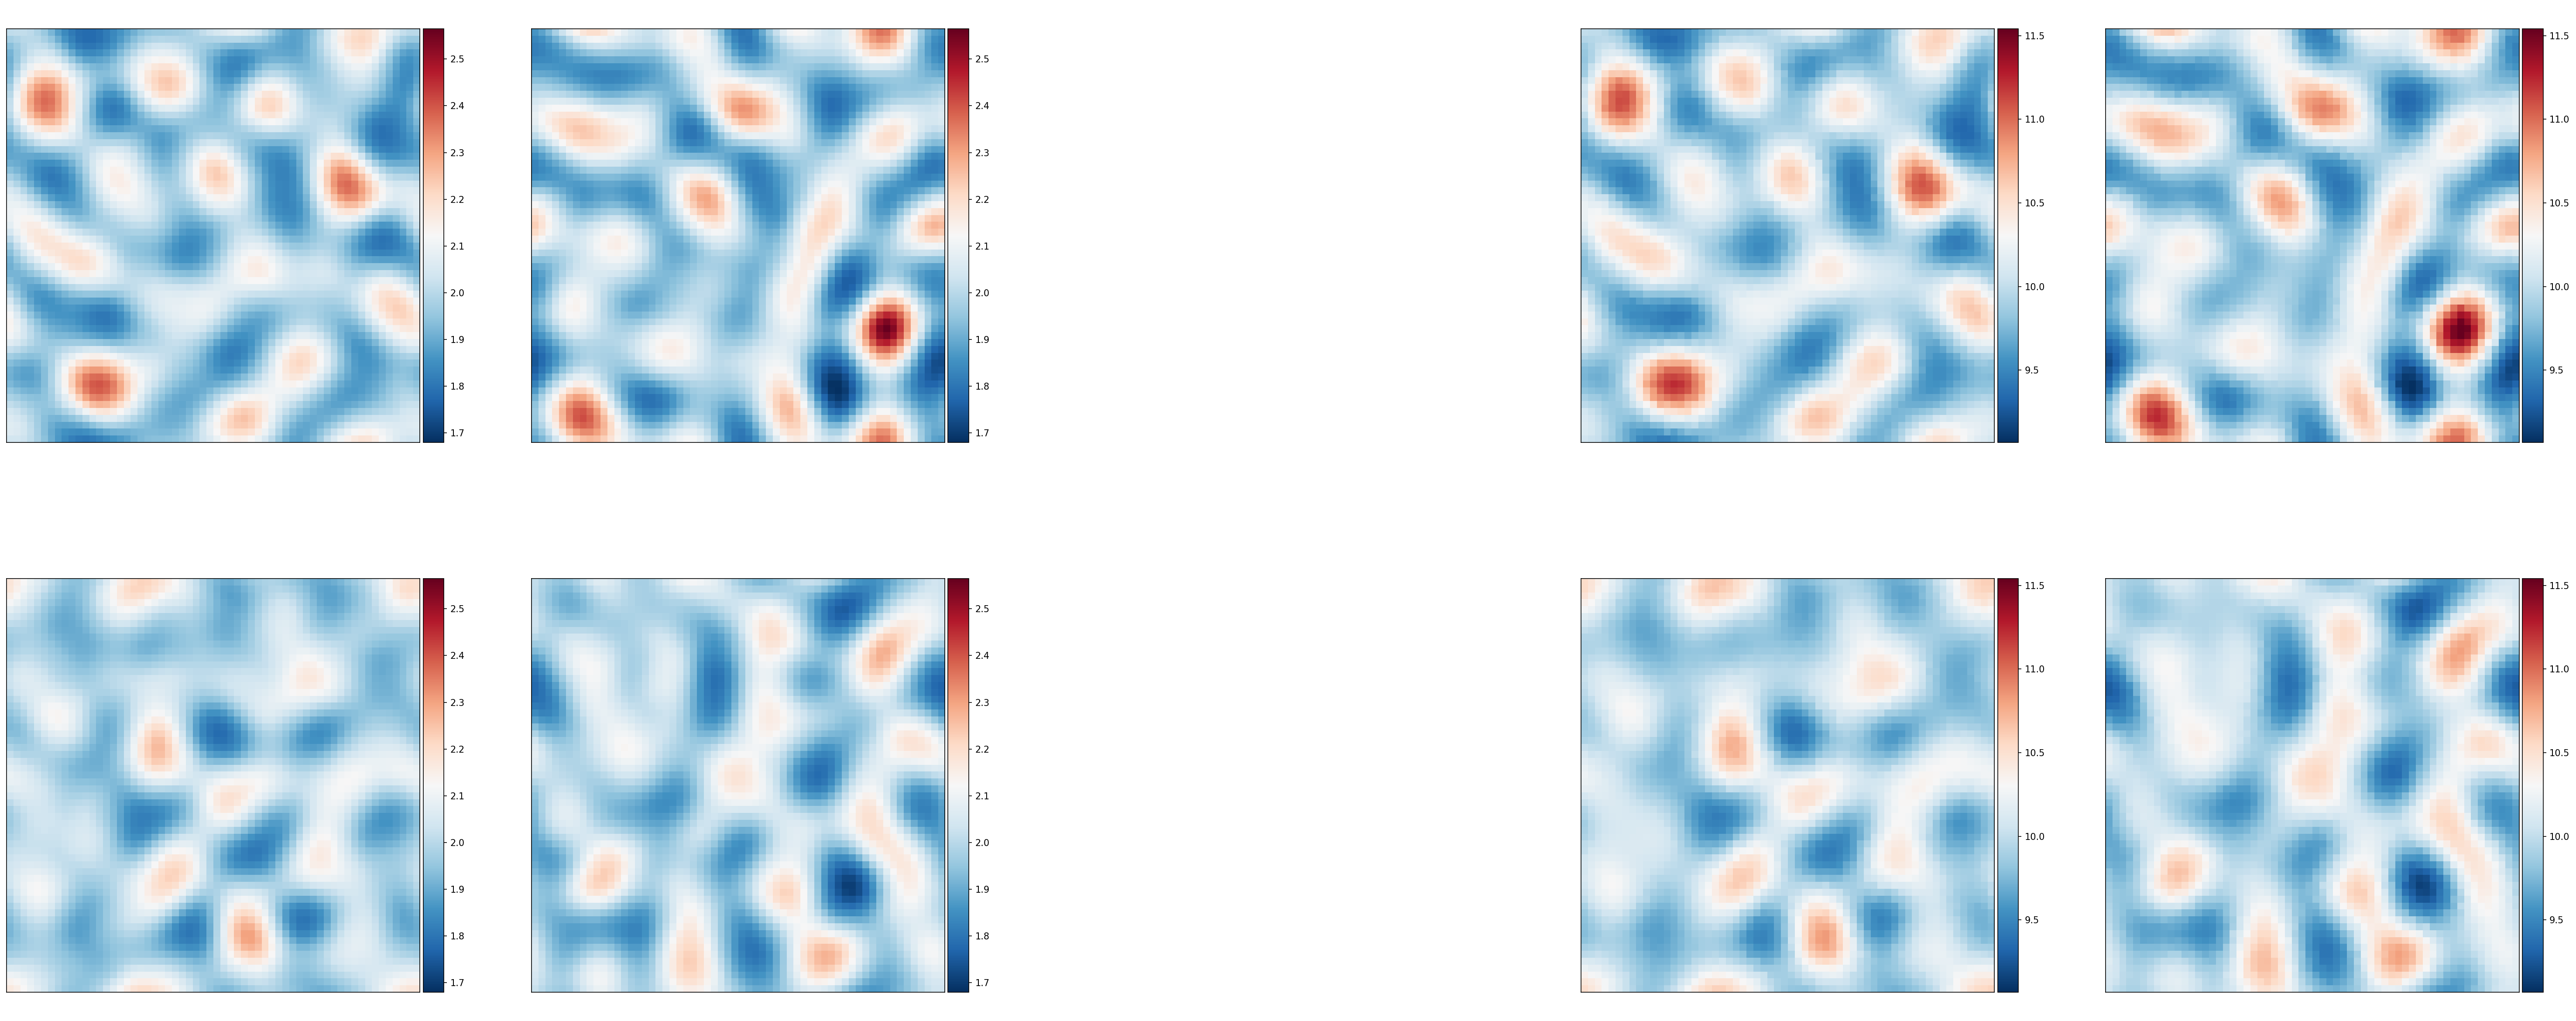

In [19]:
n_row = 2

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=((2*n_row+1)*10,n_row*10),dpi=150)

if n_row == 1:
    idx = 0
    axs[1].axis('off')
    pf.imshowbar(fig,axs[0],
                 rates[idx,0],cmap='RdBu_r',
                 vmin=np.min(rates[:,0]),vmax=np.max(rates[:,0]))
    pf.imshowbar(fig,axs[2],
                 rates[idx,1],cmap='RdBu_r',
                 vmin=np.min(rates[:,1]),vmax=np.max(rates[:,1]))
else:
    for i in range(n_row):
        axs[i,n_row].axis('off')
        for j in range(n_row):
            idx = i*n_row+j
            pf.imshowbar(fig,axs[i,j],
                         rates[idx,0],cmap='RdBu_r',
                         vmin=np.min(rates[:,0]),vmax=np.max(rates[:,0]))
            pf.imshowbar(fig,axs[i,n_row+j+1],
                         rates[idx,1],cmap='RdBu_r',
                         vmin=np.min(rates[:,1]),vmax=np.max(rates[:,1]))

# Read simulated results

In [20]:
seeds = np.arange(10)

sim_rates = [None]*len(seeds)

for seed_idx,seed in enumerate(seeds):
        with open('./../results/L23_corr_ssn/seed={:d}.pkl'.format(seed), 'rb') as handle:
            res_dict = pickle.load(handle)
        sim_rates[seed_idx] = res_dict['rates']

sim_rates = np.array(sim_rates)

In [23]:
sim_dims = np.zeros(len(seeds))

for seed_idx in range(len(seeds)):
    this_rates = sim_rates[seed_idx]
    this_rates_sub = (this_rates[:,0] - np.mean(this_rates[:,0],0)).reshape((-1,N**2))
    this_ws = np.linalg.svd(this_rates_sub,compute_uv=False)
    this_ws = this_ws**2
    sim_dims[seed_idx] = np.sum(this_ws)**2/np.sum(this_ws**2)

In [24]:
sim_dims

array([108.89791454, 109.54260306, 108.4493853 , 108.59701785,
       108.86889105, 108.55416814, 109.26239629, 108.60929533,
       108.60380178, 109.30864858])

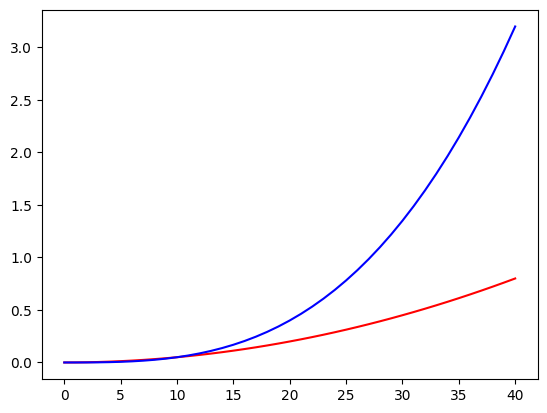

In [24]:
Vs = np.linspace(0,4,41)

plt.plot(kE*Vs**nE,'r')
plt.plot(kI*Vs**nI,'b')